# A/B testing example

Nous allons maintenant pratiquer avec ce qui pourrait être le cas le plus courant que vous pourriez rencontrer dans l’industrie en matière de tests A/B. L’entreprise possède un site web et souhaite tester quelle option entraîne le taux de conversion le plus élevé (paiement/abonnement).

**Contexte:**
L’entreprise a collecté des données auprès de près de 300 000 utilisateurs au cours du mois de janvier 2017. Les utilisateurs ont été répartis aléatoirement pour voir soit la nouvelle version, soit l’ancienne version de la page. L’entreprise vous demande de vérifier si la nouvelle page augmente le taux de conversion (le pourcentage d’utilisateurs ayant effectué l’action souhaitée, par exemple, s’abonner).

- Cette séance d'exercice se base sur : [Medium - A/B testing: A step-by-step guide in Python](https://medium.com/towards-data-science/ab-testing-with-python-e5964dd66143)
- Jeu de données source : [Kaggle - A/B Testing Dataset](https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv)
- Autre cours basé sur ces données : [Github - Analyze A/B Test Results](https://github.com/SadiqAlreemi/Analyze-AB-Test-Results)
- Autres jeux de données pour s'entraîner au A/B testing : [Open Data Stack Exchange - Sample Dataset for A/B Split Testing](https://opendata.stackexchange.com/questions/6788/where-can-i-get-a-sample-dataset-for-a-b-split-testing)


## 1. Sélection de variables

- **Aspect central**: Il s'agit d'un test A/B, où le "traitement" est attribué de manière aléatoire. Par conséquent, l'effet causal peut être mesuré en comparant le taux de conversion entre les groupes contrôle et traitement.
- **Variable de résultat (converted):** Variable binaire prenant la valeur 1 si l'utilisateur s'est abonné.
- **Variable explicative (group):** Variable catégorielle indiquant si l'utilisateur appartient au groupe contrôle ou traitement.

Dans ce cadre, nous voulons tester si le taux de conversion (une proportion) est plus élevé avec le traitement qu'avec le contrôle. Cette hypothèse peut être formulée de manière formelle comme suit :

$$H_0: p_0 \geq p_1$$
$$H_a: p_0 < p_1$$

où $p_0$ et $p_1$ représentent respectivement les taux de conversion des groupes contrôle et traitement. Ces taux sont définis comme:

$$
p_i = \frac{\text{Nombre de conversions dans le groupe } i}{\text{Nombre total d'individus dans le groupe } i}.
$$


## 2. Échantillon
- `id` : Identifiant de l'utilisateur
- `group` : Contrôle ou traitement
- `converted` : Variable binaire prenant la valeur 1 si l'utilisateur s'est abonné, et 0 sinon

### 2.1 Calcul de la taille de l’échantillon
Comme nous allons le constater, le jeu de données est très volumineux. Nous allons donc profiter de cette occasion pour calculer la taille minimale de l’échantillon nécessaire et sélectionner aléatoirement un sous-échantillon basé sur ce calcul (calcul de la taille de l’échantillon).

**a. Quel test statistique allons-nous utiliser ?**
Comme mentionné dans la section précédente, nous allons tester la différence entre deux proportions.

**b. Informations nécessaires pour calculer la taille de l’échantillon :**
- Hypothèse alternative : unilatérale.
- $\alpha=0.05$ et $\beta=0.8$ par convention.
- *Taille de l'effet* : L'équipe marketing a estimé que le retour sur investissement (suite à la mise en œuvre du changement) est rentable si la différence est d'au moins 5\%.
- *Écart-type* : Avec le test de différence de proportions, il suffit d'utiliser la taille de l'effet (l'écart-type est calculé sur la base de la proportion compte tenu de la taille de l'effet).

**c. Calcul de la taille de l’échantillon.**

In [1]:
# Importation des packages
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import datetime
# Si vous utilisez google drive
from google.colab import drive

In [13]:
# Importation des données
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/04b_ab_data.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


On a donc 5 variables. On peut ainsi avoir un rapide aperçu.

In [22]:
# Combien de temps a duré l'expérience ?
# Conversion au format datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# On créé l'object
print(df['timestamp'])


0        2017-01-21 22:11:48.556739
1        2017-01-12 08:01:45.159739
2        2017-01-11 16:55:06.154213
3        2017-01-08 18:28:03.143765
4        2017-01-21 01:52:26.210827
                    ...            
294473   2017-01-03 22:28:38.630509
294474   2017-01-12 00:51:57.078372
294475   2017-01-22 11:45:03.439544
294476   2017-01-15 01:20:28.957438
294477   2017-01-16 12:40:24.467417
Name: timestamp, Length: 294478, dtype: datetime64[ns]


In [21]:
# Vérifier la durée
print(df['timestamp'].min())
print(df['timestamp'].max())

2017-01-02 13:42:05.378582
2017-01-24 13:41:54.460509


In [18]:
# Quelle est la proportion de conversions avec le modèle actuel (control) ?
# Nous utiliserons cela comme une estimation de l'effet nul.
df.loc[df['landing_page']=='old_page', 'converted'].mean()

## On regarde toutes les obs. qui sont des old_page (ie, ancienne version de la page)
## et on regarde s'il y a eu une conversion


np.float64(12.047759085568362)

On va maintenant caculer la taille de notre échantillon pour pouvoir réaliser le test. Pour cela, nous devons 1) calculer l'effect size, puis 2) calculer le sample size (on utilisera la méthode de Cohen)

In [9]:
# Calcul de la taille de l'effet en fonction de nos taux attendus
# Le taux de conversion de base est de 0,12. Ainsi, la taille minimale de l'effet est 0,12 + 0,05 = 0,17
effect_size = sms.proportion_effectsize(0.17, 0.12 )
# La taille de l'effet est ici dérivée des travaux de Cohen : 2 * (arcsin(sqrt(prop1)) - arcsin(sqrt(prop2)))

print("La taille de l'effet est :", effect_size)

sample_size = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1,
    alternative='larger'
    )

# Toujours arrondir à l'entier supérieur pour garantir au moins la puissance attendue /!\
sample_size = ceil(sample_size)
print("Chaque groupe devrait avoir une taille de :", sample_size)

# Ou utiliser Gpower : ztest > Proportions > A priori
# Estimations assez différentes : 613 avec Gpower (dépend de la méthode d'approximation)

La taille de l'effet est : 0.14249435414546407
Chaque groupe devrait avoir une taille de : 609


### 2.2 Sélection de l'échantillon

Dans une véritable expérience, vous configureriez votre expérience et commenceriez à collecter vos données à ce stade. Dans notre cas, nous allons simplement sélectionner aléatoirement un échantillon à partir du jeu de données complet.(Bien sûr, cela est uniquement dans le cadre de l'exercice. Dans la réalité, nous utiliserions toutes les données disponibles pour augmenter la puissance.)

Mais d'abord, nettoyons les données.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [24]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Dans le jeu de données, il y a étonnamment deux colonnes qui devraient être identiques : landing_page et group. Le groupe contrôle devrait être avoir accès à l'ancienne page et le groupe traitement à la nouvelle page. Vérifions que c'est bien le cas.

In [ ]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Des individus du groupe de controle ont vu la nouvelle page, et des individus du groups traité ont vu l'ancienne !

Zut ! Pourquoi avons-nous des personnes dans le groupe contrôle qui ont vu la `new_page`, et inversement ?! Dans la vraie vie, je discuterais avec l’équipe technique pour comprendre ce qui s’est passé. En l’absence de plus d’informations, et étant donné que la proportion "d'erreurs" reste faible, nous allons exclure ces cas du jeu de données.

**/!\ IMPORTANT :** L’exclusion d’observations doit toujours être documentée !

Une ligne dans le jeu de données représente une session utilisateur. Pour préparer l’échantillon, nous allons :
1. Supprimer les erreurs repérées ci-dessus (les cas où le groupe contrôle voit la `new_page` et inversement)
2. Vérifier s’il existe des utilisateurs avec plusieurs sessions (et les supprimer)
3. Rechercher des variables manquantes
4. Sélectionner aléatoirement l’échantillon

# Suppresion des erreurs

In [40]:
# Étape 1
# Conserver uniquement si control est old_page et treatment est new_page
df_s=df.loc[((df['group']=='control') & (df['landing_page']=='old_page')) |
            ((df['group']=='treatment') & (df['landing_page']=='new_page'))]
# Vérifier avec un tableau croisé
pd.crosstab(df_s['group'], df_s['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


Explication du code:

`df_s = df.loc[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
              ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]
`
On garde uniquement:
- les personnes du groupe de contrôle qui ont vu uniquement l'ancienne page OU
- les personnes du groupe traité qui ont vu uniquement la nouvelle page

`pd.crosstab(df_s['group'], df_s['landing_page'])`

Permet d'effectuer un tableau croisé. Si notre code a fonctionné, on s'attend à ce que la diagonale soit nulle.


# Suppresion des utilisateurs avec plusieurs sessions

In [41]:
# Pour chaque user_id, on va calculer le nombre de fois où il apparait dans la base de données
session_counts = df['user_id'].value_counts()
print(session_counts)

user_id
752737    2
781280    2
767913    2
886060    2
731779    2
         ..
653383    1
732573    1
867433    1
899189    1
900200    1
Name: count, Length: 290584, dtype: int64


In [42]:
# On va maintenant identifier le nombre d'user_id qui apparaisse plus d'une fois
multi_users = session_counts[session_counts > 1].count()
print(f'Il y a {multi_users} utilisateurs qui apparaissent plusieurs fois dans le jeu de données.')

# Encore une fois, par souci de simplicité, nous allons supprimer ces observations.
# Cependant, dans la vrai vie, il serait important d'évaluer comment les traiter.
# Pouvons-nous les comparer aux autres ? Devons-nous conserver uniquement la première instance ou non ?
# Si nous les conservons toutes, l'hypothèse d'indépendance entre les observations serait violée.

Il y a 3894 utilisateurs qui apparaissent plusieurs fois dans le jeu de données.


In [44]:
# Supprimer les utilisateurs ayant plusieurs sessions

# On commence par collecter les identifiants des utilisateurs qui apparaissent plusieurs fois
users_to_drop = session_counts[session_counts > 1].index
print(users_to_drop)

Index([752737, 781280, 767913, 886060, 731779, 827432, 677313, 756804, 671874,
       741541,
       ...
       716103, 831390, 633243, 883524, 817288, 835630, 931722, 808992, 668683,
       866251],
      dtype='int64', name='user_id', length=3894)
Le jeu de données mis à jour contient maintenant 294478 entrées.


In [45]:
# On les retire ensuite de la base de données

df_s = df_s[~df_s['user_id'].isin(users_to_drop)]
# Notez que l'opérateur tilde (~) de Python est l'opérateur de négation bit à bit. Ainsi, ~0 c'est 1 et ~1 c'est 0.

print(f'Le jeu de données mis à jour contient maintenant {df.shape[0]} entrées.')

Le jeu de données mis à jour contient maintenant 294478 entrées.


# Suppresion des variables manquantes

In [46]:
# Étape 3 : valeurs manquantes ?
df_s.isnull().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


# Sélectionner aléatoirement l’échantillon

In [47]:
# Étape 4 : sélectionner un échantillon aléatoire
# random_state=1234 fixe une seed pour la génération de nombres aléatoires et permet de reproduire les résultats
control_sample = df_s[df_s['group'] == 'control'].sample(n=sample_size, random_state=1234)
treatment_sample = df_s[df_s['group'] == 'treatment'].sample(n=sample_size, random_state=1234)


,user_id,timestamp,group,landing_page,converted
0,772642,2017-01-20 14:15:39.989256,control,old_page,0
1,805427,2017-01-13 15:11:51.408191,control,old_page,0
2,640001,2017-01-05 12:32:18.803756,control,old_page,0
3,844691,2017-01-12 08:42:57.808665,control,old_page,0
4,819762,2017-01-11 14:06:23.083144,control,old_page,0
...,...,...,...,...,...
1213,815825,2017-01-18 00:36:58.005423,treatment,new_page,0
1214,919348,2017-01-11 16:01:48.490271,treatment,new_page,1
1215,833124,2017-01-22 23:11:23.000634,treatment,new_page,0
1216,650430,2017-01-17 01:25:34.678020,treatment,new_page,0


Explication du code:
- `df_s['group'] == 'control'` filtre les lignes du groupe de contrôle.
- `.sample(n=sample_size)` sélectionne de manière aléatoire les lignes de la taille de l'échantillon.
- `random_state=1234` permet que le tirage aléatoire soit reproductible - vous obtiendrez le même résultat chaque fois que vous exécuterez le code.

`treatment_sample = df_s[df_s['group'] == 'treatment'].sample(n=sample_size, random_state=1234)`fait exactement le même travail mais pour le groupe traité.


In [48]:
ab_sample = pd.concat([control_sample, treatment_sample])
ab_sample.reset_index(drop=True, inplace=True)
# "inplace" modifie directement ab_sample, et "drop" n'inclura pas une colonne avec l'ancien index dans le DataFrame.

display(ab_sample)

,user_id,timestamp,group,landing_page,converted
0,772642,2017-01-20 14:15:39.989256,control,old_page,0
1,805427,2017-01-13 15:11:51.408191,control,old_page,0
2,640001,2017-01-05 12:32:18.803756,control,old_page,0
3,844691,2017-01-12 08:42:57.808665,control,old_page,0
4,819762,2017-01-11 14:06:23.083144,control,old_page,0
...,...,...,...,...,...
1213,815825,2017-01-18 00:36:58.005423,treatment,new_page,0
1214,919348,2017-01-11 16:01:48.490271,treatment,new_page,1
1215,833124,2017-01-22 23:11:23.000634,treatment,new_page,0
1216,650430,2017-01-17 01:25:34.678020,treatment,new_page,0


Explication du code:
- `ab_sample = pd.concat([control_sample, treatment_sample])` combine les deux échantillons (contrôle et traitement) en un seul DataFrame appelé ab_sample (on les combine verticalement).
- `ab_sample.reset_index(drop=True, inplace=True)`  réinitialise l'indice de ligne de ab_sample pour qu'il passe de 0 à N-1.

En particulier, notez que:
- `drop=True`: supprime l'ancienne colonne d'index au lieu de l'ajouter à nouveau en tant que colonne.
- `inplace=True` : modifie le DataFrame en place, sans avoir à le réaffecter.



In [49]:
ab_sample['group'].value_counts()

,count
group,
control,609
treatment,609


## 3. Analyse
Commençons par utiliser des statistiques descriptives (numériques, graphiques), puis testons statistiquement la différence.

In [51]:
ab_sample[['converted', 'group']].groupby('group').describe()

converted                                             
              count      mean       std  min  25%  50%  75%  max
group                                                           
control       609.0  0.114943  0.319215  0.0  0.0  0.0  0.0  1.0
treatment     609.0  0.141215  0.348530  0.0  0.0  0.0  0.0  1.0

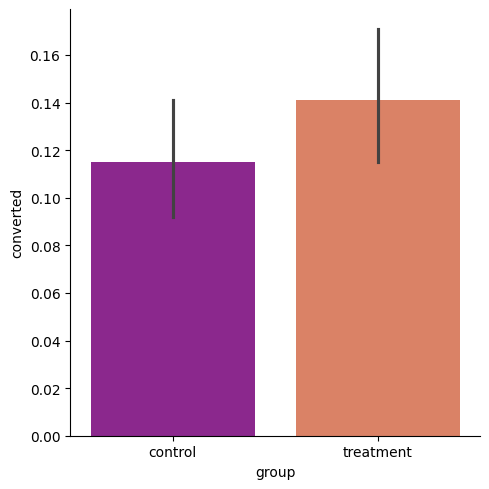

In [52]:
sns.catplot(x='group', y='converted', hue='group', palette="plasma", kind='bar', dodge=False, data=ab_sample)
plt.show()

Le groupe traitement présente un taux de conversion plus élevé. La différence est d'environ 3,1 points de pourcentage (inférieure aux 5 % attendus). Passons maintenant à un test pour déterminer si cette différence est statistiquement significative ou non.

**Test de proportion** : Les deux variables sont des variables Binomiales. Cependant, la distribution Binomiale est bien approximée par une distribution normale si $np ≥ 5$ et $n(1-p) ≥ 5$ (conditions valides ici). Plus d'informations sont disponibles ici : [PSU STAT415](https://online.stat.psu.edu/stat415/lesson/9/9.4). Nous allons utiliser la fonction `proportions_ztest` de la bibliothèque `statsmodels` pour effectuer le test. Ce module nécessite deux paires d'informations : \[nombre de succès dans le groupe contrôle, nombre de succès dans le groupe traitement\] et \[nombre d'observations dans le groupe contrôle, nombre d'observations dans le groupe traitement\].




In [53]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [56]:
# Pour chaque groupe, on va extraire la conversion
control_results = ab_sample.loc[ab_sample['group'] == 'control','converted']
treatment_results = ab_sample.loc[ab_sample['group'] == 'treatment','converted']
print(control_results)
print(treatment_results)

0      0
1      0
2      0
3      0
4      0
      ..
604    0
605    0
606    0
607    0
608    0
Name: converted, Length: 609, dtype: int64
609     1
610     0
611     0
612     0
613     0
       ..
1213    0
1214    1
1215    0
1216    0
1217    1
Name: converted, Length: 609, dtype: int64


In [61]:
n_con = control_results.count()
print(n_con)
n_treat = treatment_results.count()
print(n_treat)
successes = [control_results.sum(), treatment_results.sum()]
print(successes)
nobs = [n_con, n_treat]
print(nobs)

z_stat, pval = proportions_ztest(successes, nobs=nobs, alternative='smaller')


print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
#(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
#print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
#print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

609
609
[np.int64(70), np.int64(86)]
[np.int64(609), np.int64(609)]
z statistic: -1.37
p-value: 0.085


Conclusion : La p-value est de 0,085 ce qui est inférieur au seuil de 10\%. Par conséquent, nous pouvons rejeter l’hypothèse selon laquelle le groupe contrôle a un taux de conversion plus élevé. La différence est "seulement" de 3,1 points de pourcentage, ce qui représente un peu plus de la moitié de la différence pratique minimale suggérée par l’équipe marketing (5\%). Que pensez-vous que l’entreprise devrait faire ?